### OpenCV: Open Computer Vision Library


In [1]:
import cv2
import numpy as np

### Una pantalla como una matriz de 3 dimensiones

In [2]:
frame = np.ones([480, 680,3], dtype=np.uint8)

$$
M=
  \begin{bmatrix}
    [1,1,1] & [1,1,1] & ... & [1,1,1] \\
    [1,1,1] & [1,1,1] & ... & [1,1,1] \\
    ... & ... & ... & ... \\
    [1,1,1] & [1,1,1] & ... & [1,1,1] \\
  \end{bmatrix}
$$

In [3]:
cv2.imshow("frame", frame)
cv2.waitKey()
# remember remember to kill the frame
cv2.destroyAllWindows()

### Hagamosla blanca

$$
M=
  \begin{bmatrix}
    [255,255,255] & [255,255,255] & ... & [255,255,255] \\
    [255,255,255] & [255,255,255] & ... & [255,255,255] \\
    ... & ... & ... & ... \\
    [255,255,255] & [255,255,255] & ... & [255,255,255] \\
  \end{bmatrix}
$$

In [4]:
frame = np.ones([480, 680,3], dtype=np.uint8) * 255
cv2.imshow("frame", frame)
cv2.waitKey()
cv2.destroyAllWindows()

### Dibujemos un cubito!
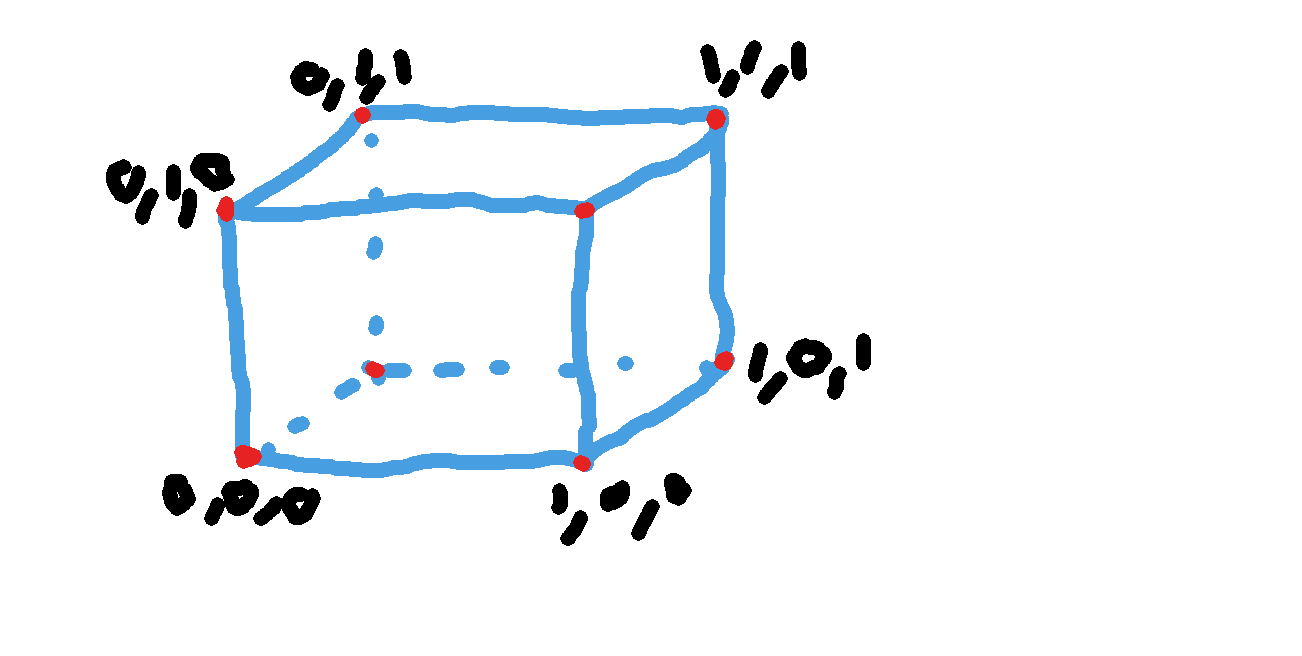
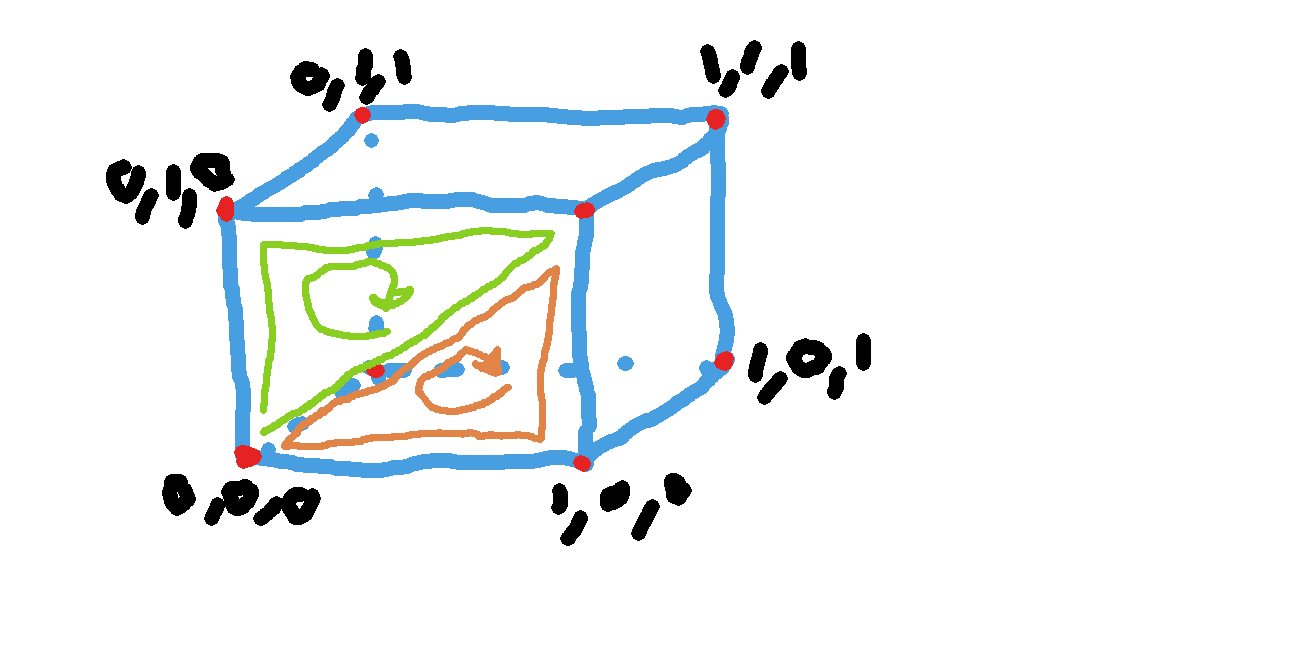
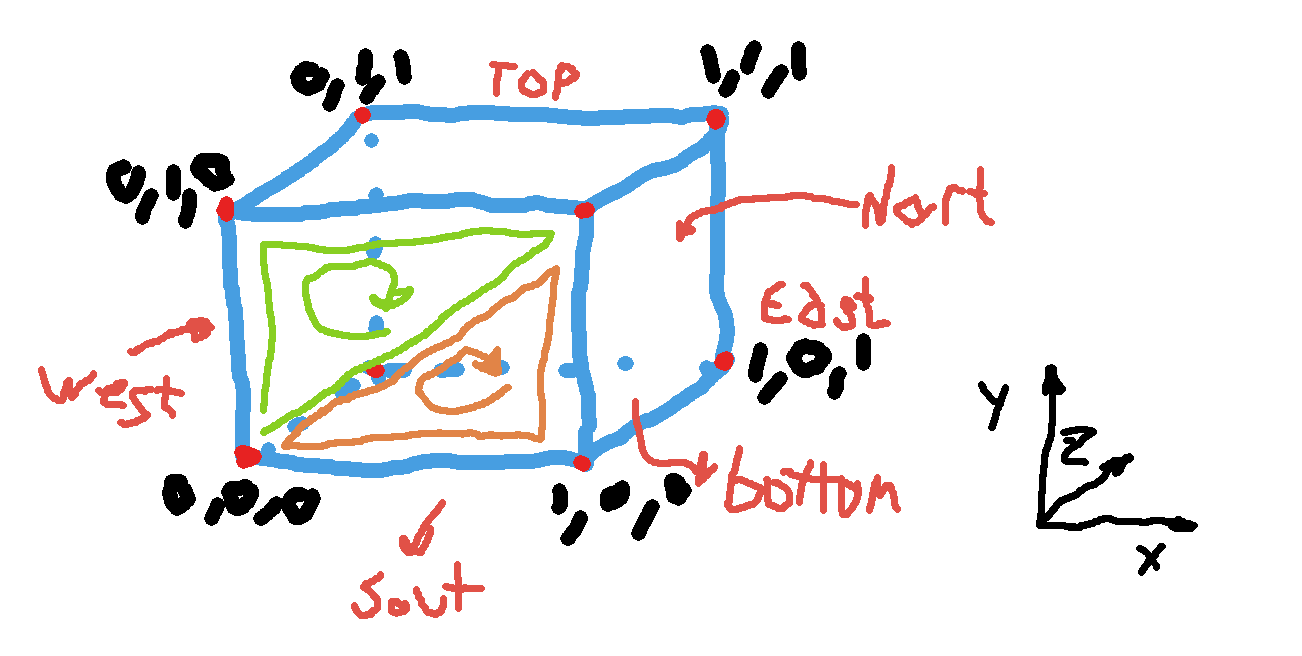

In [5]:
cubito = np.array([
        [[1, 1, 1], [0, 1, 0], [0, 1, 1]],
        [[0, 1, 0], [1, 0, 0], [0, 0, 0]],

        [[1, 1, 0], [1, 0, 1], [1, 0, 0]],
        [[0, 0, 1], [1, 0, 0], [1, 0, 1]],

        [[0, 1, 1], [0, 0, 0], [0, 0, 1]],
        [[1, 1, 1], [0, 0, 1], [1, 0, 1]],

        [[1, 1, 1], [1, 1, 0], [0, 1, 0]],
        [[0, 1, 0], [1, 1, 0], [1, 0, 0]],

        [[1, 1, 0], [1, 1, 1], [1, 0, 1]],
        [[0, 0, 1], [0, 0, 0], [1, 0, 0]],

        [[0, 1, 1], [0, 1, 0], [0, 0, 0]],
        [[1, 1, 1], [0, 1, 1], [0, 0, 1]],
])

### Como hacemos que nuestro cubito se vea en la pantalla?
## Matriz de proyección
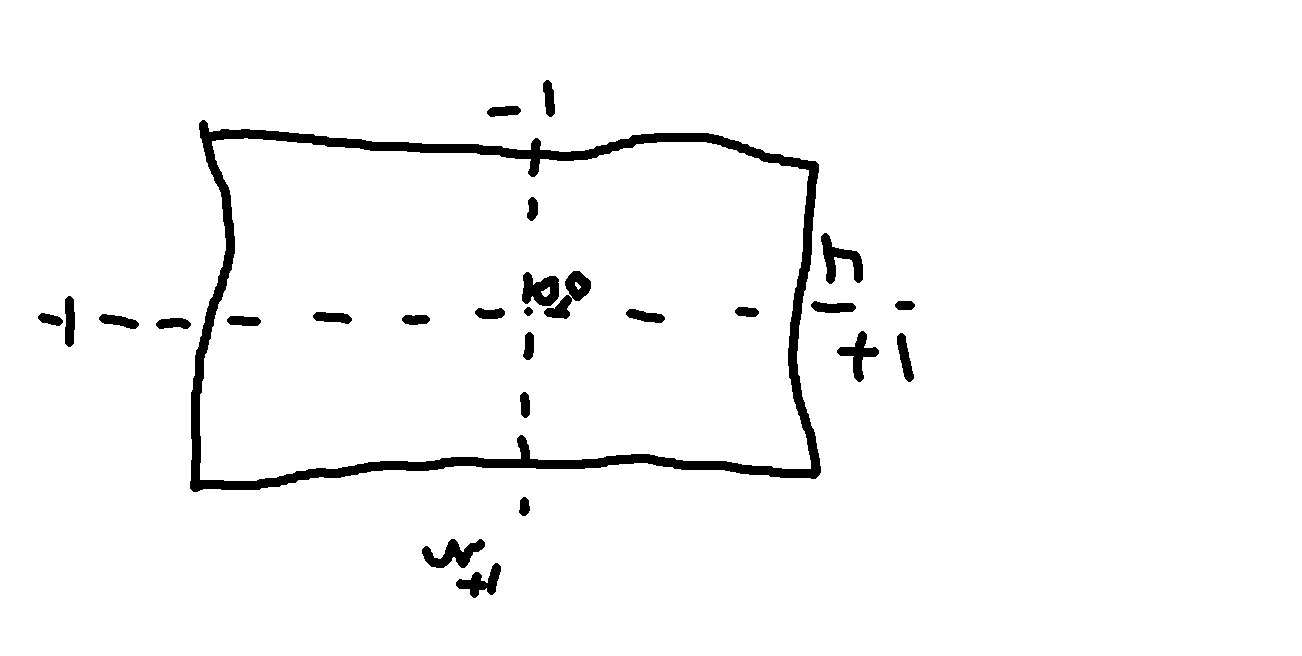
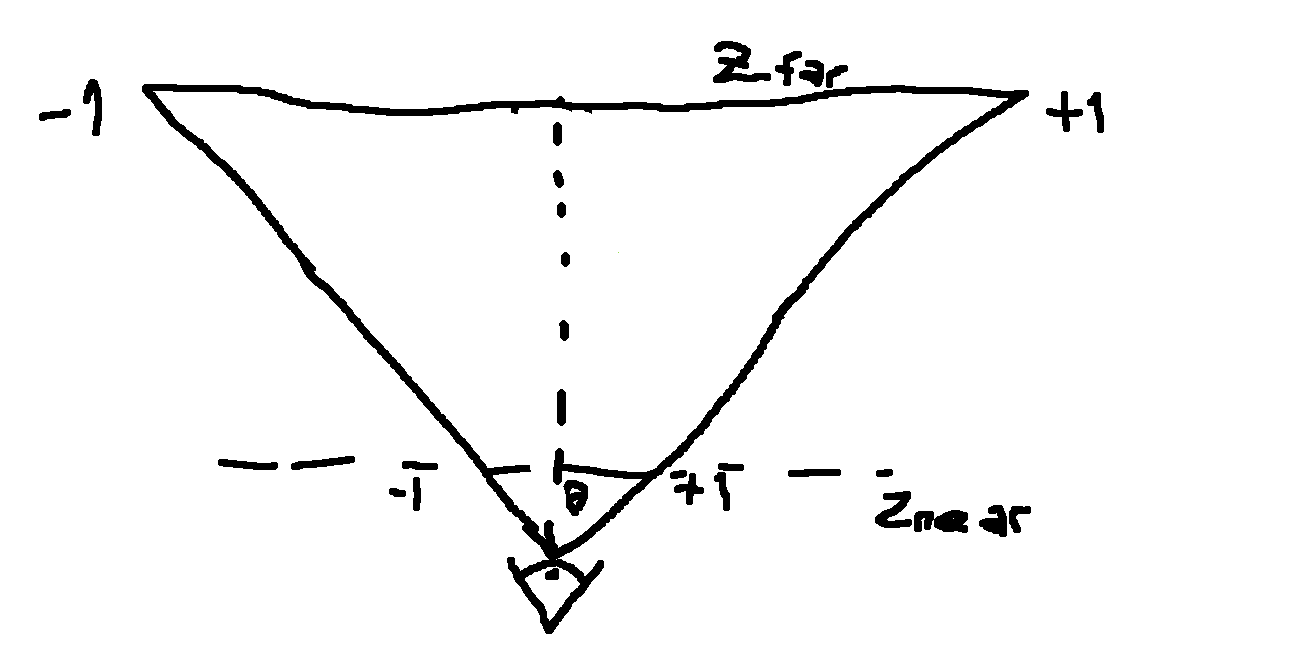

$$
M=
  \begin{bmatrix}
    (\dfrac{h}{w}) * \dfrac{1}{\tan(\tfrac{\Theta}{2})} & 0 & 0 & 0 \\
    0 & \dfrac{1}{\tan(\tfrac{\Theta}{2})} & 0 & 0 \\
    0 & 0 & \dfrac{Zfar}{Zfar-Znear} & 1\\
    0 & 0 & \dfrac{-Zfar* Znear}{Zfar-Znear} & 0\\
  \end{bmatrix}
$$

#### Simplifiquemos algunos terminos llamandolos
Aspect Ratio<br>
Field of view<br>
Z normalization <br>
$$
Proyection=
  \begin{bmatrix}
    A * F & 0 & 0 & 0 \\
    0 & F & 0 & 0 \\
    0 & 0 & Q & 1\\
    0 & 0 & Q-Znear & 0\\
  \end{bmatrix}
$$

Multiplicando la matriz de proyección por cada uno de nuestros puntos obtendremos
$$
\dfrac{AFx}{z} , \dfrac{Fy}{z} , \dfrac{Q - ZnearQ}{z}
$$

In [6]:
frame = np.ones([480, 680,3], dtype=np.uint8) * 255
screen_height, screen_width, z = frame.shape

f_near = 0.1
f_far = 1000
f_fov = 90
f_aspect_ratio = screen_height / screen_width
f_fov_rad = 1 / np.tan(f_fov * 0.5 /180 * np.pi)

af = f_aspect_ratio * f_fov_rad
f = f_fov_rad
q = f_far/(f_far-f_near)

mat_proj =  np.matrix([[ af, 0,          0, 0], 
                       [  0, f,          0, 0], 
                       [  0, 0,          q, 1],
                       [  0, 0,  -f_near*q, 0]])

def persp_transf(face):
    face = np.append(face, np.ones([3,1]), axis=1)
    res = []
    for line in face:
        l = np.matmul(line, mat_proj)
        w = l.item(3)
        if(w !=0):
            l = l * 1/w
        
        l=l[:,:3]
        res.append(l)
    return np.squeeze(np.asarray(res))

### Ya podemos renderizar?

In [7]:
def render(img, cube):
    """
    Render a basic cube
    """
   
    for points in cube:
        object_m, object_n = points.shape  
        
        points = persp_transf(points)
        
        #Transform to 2d int array
        imgpts = np.int32(points[:,:2])

        color =(255, 255, 255)
        cv2.polylines(img,[imgpts],True,color, thickness=2)

    return img

In [8]:
frame = np.ones([480, 680,3], dtype=np.uint8)
frame = render(frame, cubito)
cv2.imshow("frame", frame)
cv2.waitKey()
# remember remember to kill the frame
cv2.destroyAllWindows()

No se ve? Vamo' a escala'<br>
Para esto primero debo re posicionar el objeto ya que la matriz de proyección da resultados entre -1 y 1

$$
Translation=
  \begin{bmatrix}
    1 & 1 & 0 \\
    1 & 1 & 0 \\
    1 & 1 & 0 \\
  \end{bmatrix}
$$

$$  
Scale=
  \begin{bmatrix}
    0.5*w & 0.5*h & 1 \\
    0.5*w & 0.5*h & 1 \\
    0.5*w & 0.5*h & 1 \\
  \end{bmatrix}
$$

In [9]:
def render(img, cube):
    """
    Render a basic cube
    """
   
    for points in cube:
        object_m, object_n = points.shape
        
        # Proyecting Points
        points = persp_transf(points)
        
        # move to somewhere on the screen with a translation matrix
        x_y_move_matrix = np.ones([object_m,2], dtype=np.uint8)*1
        z_move_matrix = np.zeros([object_m,1])
        move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
        points = np.add(points,move_matrix)

        #Scale into view with scale matrix
        x_scale = 0.5 * screen_width
        y_scale = 0.5 * screen_height
        z_scale = 1
        scale_matrix = np.array([[x_scale, y_scale, z_scale],
                                 [x_scale, y_scale, z_scale],
                                 [x_scale, y_scale, z_scale]])
        points = points * scale_matrix
        
        #Transform to 2d int array
        imgpts = np.int32(points[:,:2])

        color =(255, 255, 255)
        cv2.polylines(img,[imgpts],True,color, thickness=2)

    return img

frame = np.ones([480, 680,3], dtype=np.uint8)
frame = render(frame, cubito)
cv2.imshow("frame", frame)
cv2.waitKey()
# remember remember to kill the frame
cv2.destroyAllWindows()

Que lindo!<br>
Pero tenemos el problema de que tenemos el cubo adentro de la cara, vamos a moverlo un poquito para afuera

In [10]:
def render(img, cube):
    """
    Render a basic cube
    """
   
    for points in cube:
        object_m, object_n = points.shape
        
        #Move from z
        x_y_move_matrix = np.ones([object_m,2], dtype=np.uint8)*1
        z_move_matrix = np.ones([object_m,1])*3
        z_move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
        points = np.add(points,z_move_matrix)
        
        # Proyecting Points
        points = persp_transf(points)
        
        # move to somewhere on the screen with a translation matrix
        x_y_move_matrix = np.ones([object_m,2], dtype=np.uint8)*1
        z_move_matrix = np.zeros([object_m,1])
        move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
        points = np.add(points,move_matrix)

        #Scale into view with scale matrix
        x_scale = 0.5 * screen_width
        y_scale = 0.5 * screen_height
        z_scale = 1
        scale_matrix = np.array([[x_scale, y_scale, z_scale],
                                 [x_scale, y_scale, z_scale],
                                 [x_scale, y_scale, z_scale]])
        points = points * scale_matrix
        
        #Transform to 2d int array
        imgpts = np.int32(points[:,:2])

        color =(255, 255, 255)
        cv2.polylines(img,[imgpts],True,color, thickness=2)

    return img

frame = np.ones([480, 680,3], dtype=np.uint8)
frame = render(frame, cubito)
cv2.imshow("frame", frame)
cv2.waitKey()
# remember remember to kill the frame
cv2.destroyAllWindows()

## Vamos a divertirnos un poquito

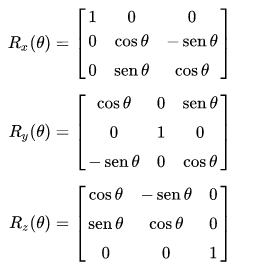

In [11]:
def render(img, cube, angle):
    """
    Render a basic cube
    """
   
    for points in cube:
        object_m, object_n = points.shape
        
        
        # Rotate With rotation Matrix
        rotation_x = np.matrix([[1, 0,             0], 
                            [0, np.cos(angle), -np.sin(angle)], 
                            [0, np.sin(angle), np.cos(angle)]])
    
        rotation_y = np.matrix([[np.cos(angle), 0, np.sin(angle)], 
                                [0, 1, 0], 
                                [-np.sin(angle), 0, np.cos(angle)]])

        rotation_z = np.matrix([[np.cos(angle), -np.sin(angle), 0], 
                                [np.sin(angle), np.cos(angle), 0], 
                                [0, 0, 1]])
        
        
        points = [np.matmul(row,rotation_x) for row in points]
        # points = [np.matmul(row,rotation_y) for row in points]
        points = [np.matmul(row,rotation_z) for row in points]
        points = np.squeeze(np.asarray(points))
        
        #Move from z
        x_y_move_matrix = np.ones([object_m,2], dtype=np.uint8)*1
        z_move_matrix = np.ones([object_m,1])*3
        z_move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
        points = np.add(points,z_move_matrix)
        
        # Proyecting Points
        points = persp_transf(points)
        
        # move to somewhere on the screen with a translation matrix
        x_y_move_matrix = np.ones([object_m,2], dtype=np.uint8)*1
        z_move_matrix = np.zeros([object_m,1])
        move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
        points = np.add(points,move_matrix)

        #Scale into view with scale matrix
        x_scale = 0.5 * screen_width
        y_scale = 0.5 * screen_height
        z_scale = 1
        scale_matrix = np.array([[x_scale, y_scale, z_scale],
                                 [x_scale, y_scale, z_scale],
                                 [x_scale, y_scale, z_scale]])
        points = points * scale_matrix
        
        #Transform to 2d int array
        imgpts = np.int32(points[:,:2])

        color =(255, 255, 255)
        cv2.polylines(img,[imgpts],True,color, thickness=2)

    return img

angle = 0
rendering = True
while rendering:
    frame = np.ones([480, 680,3], dtype=np.uint8)
    frame = render(frame, cubito, angle)
    cv2.imshow("frame", frame)
    angle += 0.01
    if cv2.waitKey(1) & 0xFF == ord("q"):
        # remember remember to kill the frame
        cv2.destroyAllWindows()
        rendering = False


Bueno pero no deberiamos de poder ver la parte de atras del cubo. <br>
Magia de las normales y el producto escalar!(dot product)
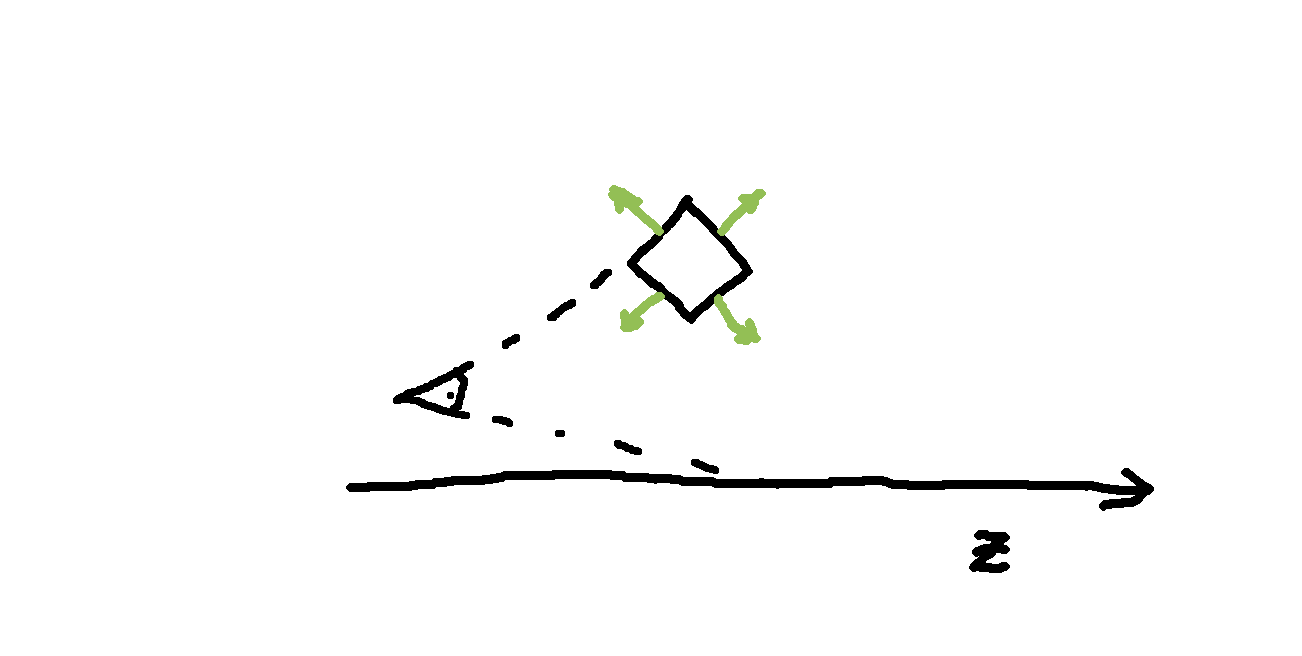

In [12]:
def render(img, cube, angle):
    """
    Render a basic cube
    """
   
    for points in cube:
        object_m, object_n = points.shape
        
        
        # Rotate With rotation Matrix
        rotation_x = np.matrix([[1, 0,             0], 
                            [0, np.cos(angle), -np.sin(angle)], 
                            [0, np.sin(angle), np.cos(angle)]])
    
        rotation_y = np.matrix([[np.cos(angle), 0, np.sin(angle)], 
                                [0, 1, 0], 
                                [-np.sin(angle), 0, np.cos(angle)]])

        rotation_z = np.matrix([[np.cos(angle), -np.sin(angle), 0], 
                                [np.sin(angle), np.cos(angle), 0], 
                                [0, 0, 1]])
        
        
        points = [np.matmul(row,rotation_x) for row in points]
        # points = [np.matmul(row,rotation_y) for row in points]
        points = [np.matmul(row,rotation_z) for row in points]
        points = np.squeeze(np.asarray(points))
        
        #Move from z
        x_y_move_matrix = np.ones([object_m,2], dtype=np.uint8)*1
        z_move_matrix = np.ones([object_m,1])*3
        z_move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
        points = np.add(points,z_move_matrix)
        
        # Get Normals and check if is visible
        line1 = points[1] - points[0]
        line2 = points[2] - points[0]
        
        normal = np.cross(line1,line2)
        norm_len = np.linalg.norm(normal)
        normal = (normal*1/norm_len)
        
        if np.dot(normal,points[0]) < 0:
            # Proyecting Points
            points = persp_transf(points)

            # move to somewhere on the screen with a translation matrix
            x_y_move_matrix = np.ones([object_m,2], dtype=np.uint8)*1
            z_move_matrix = np.zeros([object_m,1])
            move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
            points = np.add(points,move_matrix)

            #Scale into view with scale matrix
            x_scale = 0.5 * screen_width
            y_scale = 0.5 * screen_height
            z_scale = 1
            scale_matrix = np.array([[x_scale, y_scale, z_scale],
                                     [x_scale, y_scale, z_scale],
                                     [x_scale, y_scale, z_scale]])
            points = points * scale_matrix

            #Transform to 2d int array
            imgpts = np.int32(points[:,:2])

            color =(255, 255, 255)
            cv2.polylines(img,[imgpts],True,color, thickness=2)

    return img

angle = 0
rendering = True
while rendering:
    frame = np.ones([480, 680,3], dtype=np.uint8)
    frame = render(frame, cubito, angle)
    cv2.imshow("frame", frame)
    angle += 0.01
    if cv2.waitKey(1) & 0xFF == ord("q"):
        # remember remember to kill the frame
        cv2.destroyAllWindows()
        rendering = False


Vamos a dejar de lado las lineas y vamos a llenar el cubo

In [13]:
def render(img, cube, angle):
    """
    Render a basic cube
    """
   
    for points in cube:
        object_m, object_n = points.shape
        
        
        # Rotate With rotation Matrix
        rotation_x = np.matrix([[1, 0,             0], 
                            [0, np.cos(angle), -np.sin(angle)], 
                            [0, np.sin(angle), np.cos(angle)]])
    
        rotation_y = np.matrix([[np.cos(angle), 0, np.sin(angle)], 
                                [0, 1, 0], 
                                [-np.sin(angle), 0, np.cos(angle)]])

        rotation_z = np.matrix([[np.cos(angle), -np.sin(angle), 0], 
                                [np.sin(angle), np.cos(angle), 0], 
                                [0, 0, 1]])
        
        
        points = [np.matmul(row,rotation_x) for row in points]
        # points = [np.matmul(row,rotation_y) for row in points]
        points = [np.matmul(row,rotation_z) for row in points]
        points = np.squeeze(np.asarray(points))
        
        #Move from z
        x_y_move_matrix = np.ones([object_m,2], dtype=np.uint8)*1
        z_move_matrix = np.ones([object_m,1])*3
        z_move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
        points = np.add(points,z_move_matrix)
        
        # Get Normals and check if is visible
        line1 = points[1] - points[0]
        line2 = points[2] - points[0]
        
        normal = np.cross(line1,line2)
        norm_len = np.linalg.norm(normal)
        normal = (normal*1/norm_len)
        
        if np.dot(normal,points[0]) < 0:
            # Proyecting Points
            points = persp_transf(points)

            # move to somewhere on the screen with a translation matrix
            x_y_move_matrix = np.ones([object_m,2], dtype=np.uint8)*1
            z_move_matrix = np.zeros([object_m,1])
            move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
            points = np.add(points,move_matrix)

            #Scale into view with scale matrix
            x_scale = 0.5 * screen_width
            y_scale = 0.5 * screen_height
            z_scale = 1
            scale_matrix = np.array([[x_scale, y_scale, z_scale],
                                     [x_scale, y_scale, z_scale],
                                     [x_scale, y_scale, z_scale]])
            points = points * scale_matrix

            #Transform to 2d int array
            imgpts = np.int32(points[:,:2])
            
            #Fill triangle
            color = np.array([0, 204, 255])
            color = list(color[::-1])
            color = [int(c) for c in color]
            cv2.fillConvexPoly(img, imgpts, color)
            

    return img

angle = 0
rendering = True
while rendering:
    frame = np.ones([480, 680,3], dtype=np.uint8)
    frame = render(frame, cubito, angle)
    cv2.imshow("frame", frame)
    angle += 0.01
    if cv2.waitKey(1) & 0xFF == ord("q"):
        # remember remember to kill the frame
        cv2.destroyAllWindows()
        rendering = False


Let there be light!

In [14]:
def render(img, cube, angle):
    """
    Render a basic cube
    """
   
    for points in cube:
        object_m, object_n = points.shape
        
        
        # Rotate With rotation Matrix
        rotation_x = np.matrix([[1, 0,             0], 
                            [0, np.cos(angle), -np.sin(angle)], 
                            [0, np.sin(angle), np.cos(angle)]])
    
        rotation_y = np.matrix([[np.cos(angle), 0, np.sin(angle)], 
                                [0, 1, 0], 
                                [-np.sin(angle), 0, np.cos(angle)]])

        rotation_z = np.matrix([[np.cos(angle), -np.sin(angle), 0], 
                                [np.sin(angle), np.cos(angle), 0], 
                                [0, 0, 1]])
        
        
        points = [np.matmul(row,rotation_x) for row in points]
        # points = [np.matmul(row,rotation_y) for row in points]
        points = [np.matmul(row,rotation_z) for row in points]
        points = np.squeeze(np.asarray(points))
        
        #Move from z
        x_y_move_matrix = np.ones([object_m,2], dtype=np.uint8)*1
        z_move_matrix = np.ones([object_m,1])*3
        z_move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
        points = np.add(points,z_move_matrix)
        
        # Get Normals and check if is visible
        line1 = points[1] - points[0]
        line2 = points[2] - points[0]
        
        normal = np.cross(line1,line2)
        norm_len = np.linalg.norm(normal)
        normal = (normal*1/norm_len)
        
        if np.dot(normal,points[0]) < 0:
             #Lighting!
            light_len = np.linalg.norm(directional_light)
            light_normal = (directional_light*1/light_len)
            
            lum_val = np.dot(normal,light_normal)
            
            # Proyecting Points
            points = persp_transf(points)

            # move to somewhere on the screen with a translation matrix
            x_y_move_matrix = np.ones([object_m,2], dtype=np.uint8)*1
            z_move_matrix = np.zeros([object_m,1])
            move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
            points = np.add(points,move_matrix)

            #Scale into view with scale matrix
            x_scale = 0.5 * screen_width
            y_scale = 0.5 * screen_height
            z_scale = 1
            scale_matrix = np.array([[x_scale, y_scale, z_scale],
                                     [x_scale, y_scale, z_scale],
                                     [x_scale, y_scale, z_scale]])
            points = points * scale_matrix

            #Transform to 2d int array
            imgpts = np.int32(points[:,:2])
            
            #Fill triangle
            color = np.array([0, 204, 255]) * lum_val
            color = list(color[::-1])
            color = [int(c) for c in color]
            cv2.fillConvexPoly(img, imgpts, color)
    return img

directional_light = np.array([0,0,-1])
angle = 0
rendering = True
while rendering:
    frame = np.ones([480, 680,3], dtype=np.uint8)
    frame = render(frame, cubito, angle)
    cv2.imshow("frame", frame)
    angle += 0.01
    if cv2.waitKey(1) & 0xFF == ord("q"):
        # remember remember to kill the frame
        cv2.destroyAllWindows()
        rendering = False


Hacer figuras es aburrido, que tal cargar un objeto de un programa como blender?<br>
El archivo OBJ se divide en<br>
<br>
Comments<br>
Vertex<br>
Faces<br>

In [15]:
from objloader_simple import OBJ
fox = OBJ("models/fox.obj")

In [16]:
def render(img, obj, angle):
    """
    Render a basic cube
    """
    vertices = obj.vertices
    
    # rotation Matrix
    rotation_x = np.matrix([[1, 0,             0], 
                        [0, np.cos(angle), -np.sin(angle)], 
                        [0, np.sin(angle), np.cos(angle)]])

    rotation_y = np.matrix([[np.cos(angle), 0, np.sin(angle)], 
                            [0, 1, 0], 
                            [-np.sin(angle), 0, np.cos(angle)]])

    rotation_z = np.matrix([[np.cos(angle), -np.sin(angle), 0], 
                            [np.sin(angle), np.cos(angle), 0], 
                            [0, 0, 1]])

    for face in obj.faces:
        face_vertices = face[0]
        points = np.array([vertices[vertex - 1] for vertex in face_vertices])
        
        object_m, object_n = points.shape
        
        
        # Rotate With 
        # points = [np.matmul(row,rotation_x) for row in points]
        # points = [np.matmul(row,rotation_y) for row in points]
        points = [np.matmul(row,rotation_z) for row in points]
        points = np.squeeze(np.asarray(points))
        
        #Move from z
        x_y_move_matrix = np.ones([object_m,2], dtype=np.uint8)*1
        z_move_matrix = np.ones([object_m,1])*5
        z_move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
        points = np.add(points,z_move_matrix)
        
        # Get Normals and check if is visible
        line1 = points[1] - points[0]
        line2 = points[2] - points[0]
        
        normal = np.cross(line1,line2)
        norm_len = np.linalg.norm(normal)
        normal = (normal*1/norm_len)
        
        if np.dot(normal,points[0]) < 0:
             #Lighting!
            light_len = np.linalg.norm(directional_light)
            light_normal = (directional_light*1/light_len)
            
            lum_val = np.dot(normal,light_normal)
            
            # Proyecting Points
            points = persp_transf(points)

            # move to somewhere on the screen with a translation matrix
            x_y_move_matrix = np.ones([object_m,2], dtype=np.uint8)*1.5
            z_move_matrix = np.zeros([object_m,1])
            move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
            points = np.add(points,move_matrix)

            #Scale into view with scale matrix
            x_scale = 0.5 * screen_width
            y_scale = 0.5 * screen_height
            z_scale = 1
            scale_matrix = np.array([[x_scale, y_scale, z_scale],
                                     [x_scale, y_scale, z_scale],
                                     [x_scale, y_scale, z_scale]])
            points = points * scale_matrix

            #Transform to 2d int array
            imgpts = np.int32(points[:,:2])
            
            #Fill triangle
            color = np.array([0, 204, 255]) * lum_val
            color = list(color[::-1])
            color = [int(c) for c in color]
            cv2.fillConvexPoly(img, imgpts, color)
    return img

directional_light = np.array([0,0,-1])
angle = 0
rendering = True
while rendering:
    frame = np.ones([720, 1280,3], dtype=np.uint8)
    frame = render(frame, fox, angle)
    cv2.imshow("frame", frame)
    angle += 0.04
    if cv2.waitKey(1) & 0xFF == ord("q"):
        # remember remember to kill the frame
        cv2.destroyAllWindows()
        rendering = False


In [1]:
def render(img, obj, angle):
    """
    Render a basic cube
    """
    vertices = obj.vertices
    
    # rotation Matrix
    rotation_x = np.matrix([[1, 0,             0], 
                        [0, np.cos(angle), -np.sin(angle)], 
                        [0, np.sin(angle), np.cos(angle)]])

    rotation_y = np.matrix([[np.cos(angle), 0, np.sin(angle)], 
                            [0, 1, 0], 
                            [-np.sin(angle), 0, np.cos(angle)]])

    rotation_z = np.matrix([[np.cos(angle), -np.sin(angle), 0], 
                            [np.sin(angle), np.cos(angle), 0], 
                            [0, 0, 1]])
    
    unsorted_faces = []
    for face in obj.faces:
        face_vertices = face[0]
        points = np.array([vertices[vertex - 1] for vertex in face_vertices])
        
        object_m, object_n = points.shape
        
        
        # Rotate With 
        # points = [np.matmul(row,rotation_x) for row in points]
        # points = [np.matmul(row,rotation_y) for row in points]
        points = [np.matmul(row,rotation_z) for row in points]
        points = np.squeeze(np.asarray(points))
        
        #Move from z
        x_y_move_matrix = np.ones([object_m,2], dtype=np.uint8)*1
        z_move_matrix = np.ones([object_m,1])*5
        z_move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
        points = np.add(points,z_move_matrix)
        
        # Get Normals and check if is visible
        line1 = points[1] - points[0]
        line2 = points[2] - points[0]
        
        normal = np.cross(line1,line2)
        norm_len = np.linalg.norm(normal)
        normal = (normal*1/norm_len)
        
        if np.dot(normal,points[0]) < 0:
             #Lighting!
            light_len = np.linalg.norm(directional_light)
            light_normal = (directional_light*1/light_len)
            
            lum_val = np.dot(normal,light_normal)
            
            # Proyecting Points
            points = persp_transf(points)

            # move to somewhere on the screen with a translation matrix
            x_y_move_matrix = np.ones([object_m,2], dtype=np.uint8)*1.5
            z_move_matrix = np.zeros([object_m,1])
            move_matrix = np.append(x_y_move_matrix, z_move_matrix, axis=1)
            points = np.add(points,move_matrix)

            #Scale into view with scale matrix
            x_scale = 0.5 * screen_width
            y_scale = 0.5 * screen_height
            z_scale = 1
            scale_matrix = np.array([[x_scale, y_scale, z_scale],
                                     [x_scale, y_scale, z_scale],
                                     [x_scale, y_scale, z_scale]])
            points = points * scale_matrix
            
            unsorted_faces.append(points)
    
    
    for poins in viewing_faces:
            #Transform to 2d int array
            imgpts = np.int32(points[:,:2])
            
            #Fill triangle
            color = np.array([0, 204, 255]) * lum_val
            color = list(color[::-1])
            color = [int(c) for c in color]
            cv2.fillConvexPoly(img, imgpts, color)
    return img

directional_light = np.array([0,0,-1])
angle = 0
rendering = True
while rendering:
    frame = np.ones([720, 1280,3], dtype=np.uint8)
    frame = render(frame, fox, angle)
    cv2.imshow("frame", frame)
    angle += 0.04
    if cv2.waitKey(1) & 0xFF == ord("q"):
        # remember remember to kill the frame
        cv2.destroyAllWindows()
        rendering = False


NameError: name 'np' is not defined